In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from PIL import Image
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import files

In [ ]:
CONFIGURATION = {
    "BATCH_SIZE": 16,  # Increased for better convergence
    "IM_SIZE": 224,
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 50,
    "DROPOUT_RATE": 0.5,  # Increased to combat overfitting
    "REGULARIZATION_RATE": 0.001,
    "CLASS_NAMES": ["Grade 1", "Grade 2", "Grade 3"],
    "N_FILTERS": 32,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 64,  # Reduced to avoid overfitting
    "N_DENSE_2": 32,  # Reduced to avoid overfitting
    "NUM_CLASSES": 3
}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Specify the path to your zip file and the extraction directory
zip_file_path = '/content/drive/MyDrive/Model_efficientNet.zip'
extract_to = '/content/Model_efficientNet'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Open and extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("File unzipped successfully!")

File unzipped successfully!


In [ ]:
train_directory = "/content/Model_efficientNet/Model_efficientNet/Train_Acne"
val_directory = "/content/Model_efficientNet/Model_efficientNet/Test_Acne"

In [ ]:
import os
import shutil

# Define the path to your dataset directory
dataset_directory = "/content/Model_efficientNet/Model_efficientNet/Train_Acne"

# Recursively find and remove any .ipynb_checkpoints folders
for root, dirs, files in os.walk(dataset_directory):
    for dir_name in dirs:
        if dir_name == ".ipynb_checkpoints":
            checkpoint_path = os.path.join(root, dir_name)
            shutil.rmtree(checkpoint_path)
            print(f"Removed: {checkpoint_path}")

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',  # Use 'categorical' for one-hot encoded labels
    class_names=CONFIGURATION["CLASS_NAMES"],  # Ensure class names match the folder structure
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)


Found 5701 files belonging to 3 classes.


In [ ]:
import tensorflow as tf

# Load the validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',  # Use 'categorical' for one-hot encoded labels
    class_names=CONFIGURATION["CLASS_NAMES"],  # Ensure class names match the folder structure
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=False,  # No need to shuffle validation data
    seed=99,
)


Found 1427 files belonging to 3 classes.


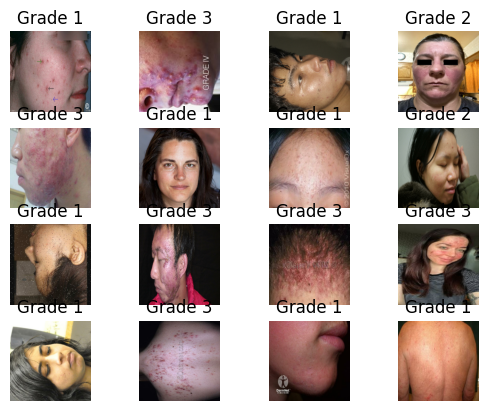

In [ ]:
import matplotlib.pyplot as plt
CLASS_NAMES = CONFIGURATION["CLASS_NAMES"]
for images,labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i],axis=0).numpy()])
    plt.axis("off")

In [ ]:
training_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
val_dataset = (
    validation_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
from tensorflow.keras.layers import Resizing,Rescaling
IM_SIZE = 224
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_SIZE,IM_SIZE),
    Rescaling(1./255),
])

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, BatchNormalization
from tensorflow.keras import Sequential

# Define the VGG19 backbone
backbone = VGG19(
    include_top=False,  # Exclude the top fully connected layers
    weights='imagenet',  # Load pre-trained weights
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
)

# Freeze the backbone layers
backbone.trainable = False

# Build the model
pretrained_model = Sequential([
    Input(shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3)),
    backbone,  # Add the VGG19 backbone
    GlobalAveragePooling2D(),  # Add a global average pooling layer
    Dense(CONFIGURATION["N_DENSE_1"], activation="relu"),  # First dense layer
    BatchNormalization(),  # Batch normalization for stable training
    Dense(CONFIGURATION["N_DENSE_2"], activation="relu"),  # Second dense layer
    Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax"),  # Output layer
])

# Print model summary
pretrained_model.summary()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,059,651 (76.52 MB)

 Trainable params: 35,139 (137.26 KB)

 Non-trainable params: 20,024,512 (76.39 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ModelCheckpoint to save the best weights
checkpoint_callback = ModelCheckpoint(
    filepath='best_weights_multiclass.keras',  # Save weights in a clear filename
    monitor='val_categorical_accuracy',                # Monitor validation accuracy
    mode='max',                            # Maximize validation accuracy
    verbose=1,                             # Display messages when saving
    save_best_only=True                    # Save only the best weights
)

# EarlyStopping to stop training early when no improvement
early_stopping_callback = EarlyStopping(
    monitor='val_categorical_accuracy',      # Monitor validation accuracy
    mode='max',                  # Maximize validation accuracy
    patience=5,                  # Number of epochs with no improvement to wait
    verbose=1,                   # Display messages when stopping
    restore_best_weights=True    # Restore the best weights after stopping
)

# Combine both callbacks
callbacks = [checkpoint_callback, early_stopping_callback]


In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy

# Use CategoricalCrossentropy if labels are one-hot encoded
loss_function = CategoricalCrossentropy()

# OR, use SparseCategoricalCrossentropy if labels are integers
# loss_function = SparseCategoricalCrossentropy()


In [ ]:
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall
import tensorflow as tf

# Custom F1 Score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Define the metrics
metrics = [
    CategoricalAccuracy(name='categorical_accuracy'),  # For multiclass accuracy
    Precision(name="precision"),                      # Precision across all classes
    Recall(name="recall"),                            # Recall across all classes
    F1Score(name="f1_score")                          # Custom F1 score
]


In [ ]:
pretrained_model.compile(
    optimizer=Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
history = pretrained_model.fit(
    training_dataset,
    validation_data = val_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1,
    callbacks = checkpoint_callback
)

Epoch 1/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - categorical_accuracy: 0.4868 - f1_score: 0.4283 - loss: 1.0460 - precision: 0.5563 - recall: 0.3483
Epoch 1: val_categorical_accuracy improved from -inf to 0.61388, saving model to best_weights_multiclass.keras
357/357 ━━━━━━━━━━━━━━━━━━━━ 96s 231ms/step - categorical_accuracy: 0.4869 - f1_score: 0.4285 - loss: 1.0457 - precision: 0.5565 - recall: 0.3484 - val_categorical_accuracy: 0.6139 - val_f1_score: 0.5890 - val_loss: 0.8617 - val_precision: 0.6687 - val_recall: 0.5263
Epoch 2/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - categorical_accuracy: 0.6400 - f1_score: 0.5932 - loss: 0.7862 - precision: 0.7051 - recall: 0.5120
Epoch 2: val_categorical_accuracy improved from 0.61388 to 0.64821, saving model to best_weights_multiclass.keras
357/357 ━━━━━━━━━━━━━━━━━━━━ 71s 198ms/step - categorical_accuracy: 0.6400 - f1_score: 0.5932 - loss: 0.7861 - precision: 0.7051 - recall: 0.5121 - val_categorical_accuracy: 0.6482 - val_f1_score

In [ ]:
pretrained_model.evaluate(val_dataset)

90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - categorical_accuracy: 0.8048 - f1_score: 0.8065 - loss: 0.8541 - precision: 0.8103 - recall: 0.8028


[1.1299916505813599,
 0.7421163320541382,
 0.7475247383117676,
 0.7407147884368896,
 0.7441041469573975]

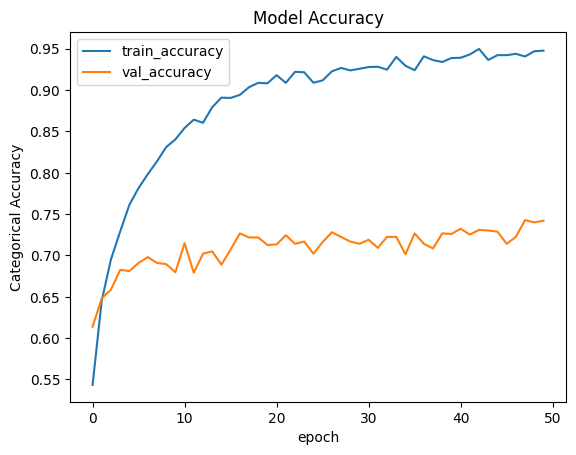

In [ ]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Categorical Accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

Confusion Matrix:
 [[396  41  28]
 [ 82 242 119]
 [ 50  48 421]]


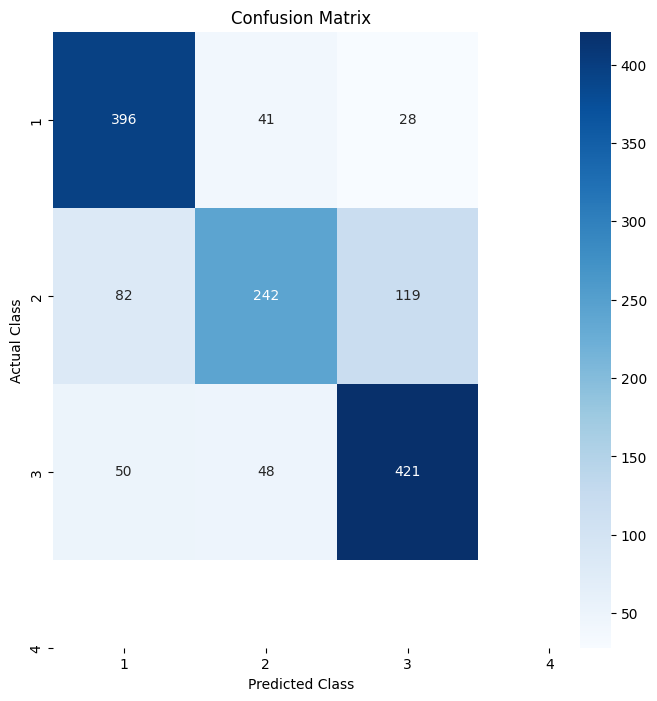

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

predicted = []
labels = []

# Iterate through validation data
for images, label in val_dataset:
    # Get predictions for the batch
    batch_preds = pretrained_model(images, training=False)

    # Convert probabilities to class labels (argmax to get class index)
    batch_preds = np.argmax(batch_preds.numpy(), axis=1)
    predicted.extend(batch_preds)  # Collect all predictions

    # Flatten and collect true labels
    labels.extend(np.argmax(label.numpy(), axis=1))  # Ensure labels are in class index form

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predicted)
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix as a heatmap with indices starting from 1
plt.figure(figsize=(8, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=range(1, 5),  # Change range to start from 1
    yticklabels=range(1, 5)   # Change range to start from 1
)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


In [ ]:
pretrained_model.save("/content/drive/MyDrive/ACNE_MODELS/efficientNetB7.keras")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ACNE_MODELS/efficientNetB7.keras'